In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import random
import numpy as np
import pandas as pd
import math
from scipy.spatial.distance import cdist, euclidean


## Utils

In [4]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


In [5]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
def group_emisions(data):
    data_dict = data.asDict()
    recep_0 = data_dict.pop('recep_0')
    recep_1 = data_dict.pop('recep_1')
    recep_2 = data_dict.pop('recep_2')
    recep_3 = data_dict.pop('recep_3')
    
    data_dict['emissions'] = []
    for i in range(24):
        data_dict['emissions'].append([recep_0[i], recep_1[i], recep_2[i], recep_3[i]])
    return data_dict


In [8]:
points_emisions = points_recep.map(group_emisions)


In [10]:
def expand_rows_with_emissions(row):
    emissions = row.pop('emissions')
    rows = []
    for e in emissions:
        new_row = row.copy()
        new_row['recep'] = e
        rows.append(new_row)
    return rows
        
all_emissions = points_emisions.flatMap(expand_rows_with_emissions)

### Genero los atributos y etiquetas que me interesan

In [11]:
def generate_attrs(row):
    data = {
        'antenna_0': row['recep'][0],
        'antenna_1': row['recep'][1],
        'antenna_2': row['recep'][2],
        'antenna_3': row['recep'][3],
    }
    return {'data': data, 'x': row['x'], 'y': row['y'], 'point': row['Punto']}
    
all_emissions = all_emissions.map(generate_attrs)

### Saco las emisiones sin ninguna recepcion

In [12]:
all_emissions = all_emissions.filter(lambda x: sum(x['data'].values())>0)

In [16]:
same_signals_points = all_emissions.groupBy(lambda x: str(x['data'])).map(lambda x: list(x[1]))

In [18]:
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [19]:
def calc_min_err(emissions):
    min_dist_sum = 1000000
    for i in range(len(emissions)):
        distances_sum = 0
        for j in range(len(emissions)):
            if i != j:
                p1 = (emissions[i]['x'], emissions[i]['y'])
                p2 = (emissions[j]['x'], emissions[j]['y'])
                distances_sum += distance(p1, p2)
        min_dist_sum = min(min_dist_sum, distances_sum)
        
    pos = np.array([[e['x'],e['y']] for e in emissions])
    best_point = geometric_median(pos)
    distances_sum = 0
    for i in range(len(emissions)):
        p1 = (emissions[i]['x'], emissions[i]['y'])
        p2 = best_point
        distances_sum += distance(p1, p2)
    min_dist_sum = min(min_dist_sum, distances_sum)
    
    return [min_dist_sum, len(emissions), emissions[0]['data']]



In [20]:
sum_min_dist = same_signals_points.map(calc_min_err).map(lambda x: x[0]).sum()
total_emmisions = all_emissions.count()

min_mae = sum_min_dist/float(total_emmisions)
min_mae

226.8865060208359

### Peores emisiones (es decir, que causan mayor error)

In [21]:
worst_emissions = same_signals_points.map(calc_min_err)

In [22]:
worst_emissions.sortBy(lambda x: -x[0]/float(x[1])).map(lambda x: (x[0]/float(x[1]),x[1],x[2])).take(20)

[(899.9594161637845,
  2,
  {'antenna_0': 17, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (728.8024608069928,
  23,
  {'antenna_0': 27, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (725.130917146292,
  9,
  {'antenna_0': 24, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (702.8870003255713,
  35,
  {'antenna_0': 30, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (697.6903595023781,
  24,
  {'antenna_0': 28, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (693.7969394107854,
  38,
  {'antenna_0': 33, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (644.2984984913761,
  54,
  {'antenna_0': 35, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (639.7459990614332,
  29,
  {'antenna_0': 29, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (635.9651115425371,
  5,
  {'antenna_0': 18, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (635.1146450199922,
  38,
  {'antenna_0': 34, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 0}),
 (624.2779191842491,
  59,
  {'ant

### Map utils

In [23]:
import matplotlib.pyplot as plt

global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 
global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


In [24]:
def show_same_emissions_points(emissions):
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    ax = all_points_pos.plot.scatter(x='x', y='y',c='#96EAE1')
    for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        name = nombre_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 
        
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)

    
    for i in range(len(emissions)):
        point = emissions[i]
        plt.scatter(point['x']-x_0, point['y']-y_0, c='g', s=15)

        


{'antenna_0': 0, 'antenna_1': 50, 'antenna_2': 0, 'antenna_3': 0}
aprox min distance error 209.9860225441256


<IPython.core.display.Javascript object>


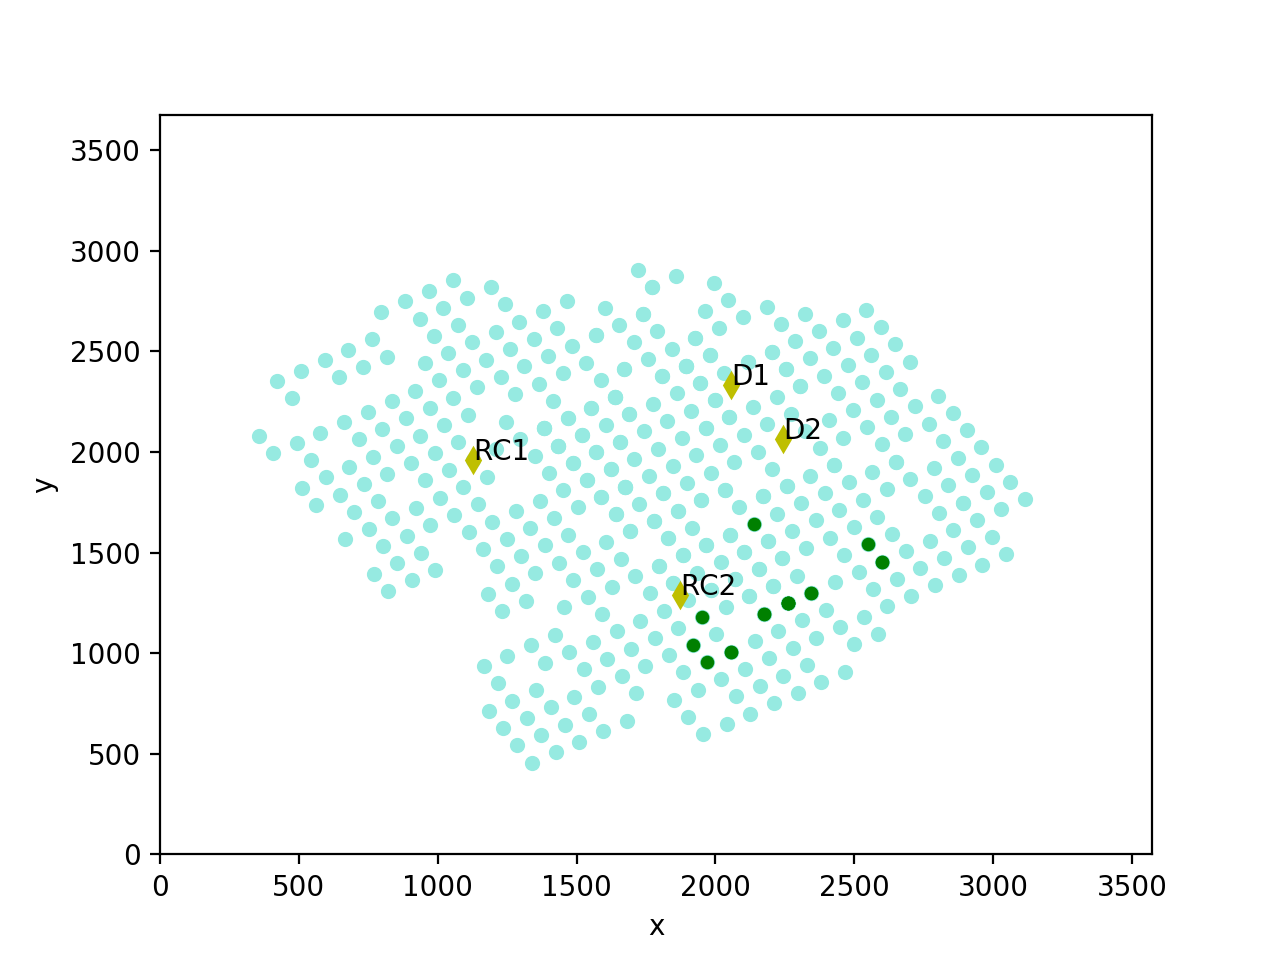

In [27]:
sample = same_signals_points.filter(lambda x: len(x) > 1 and x[0] != x[-1]).takeSample(False, 1)[0]
print(sample[0]['data'])
print('aprox min distance error', calc_min_err(sample)[0]/float(len(sample)))
show_same_emissions_points(sample)